In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from xgboost import XGBRegressor

!pip install -q shap
import shap

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']
colorss = ['#b2c3d4', '#414487', '#B01756']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

# **DATASET LOADING**

In [5]:
df_train = pd.read_csv('../data/processed/02_Train.csv')

df_val = pd.read_csv('../data/processed/02_Validation.csv')

df_test = pd.read_csv('../data/processed/02_Test.csv')

df = pd.date_range(start = '2025-03-01', end = '2025-04-30', freq = 'D')
df = pd.DataFrame({'date': df})

# **DATASET SPLITTING**

In [7]:
X_train = df_train.drop('sell_quantity_log', axis = 1).copy()
y_train = df_train['sell_quantity_log'].copy()

X_val = df_val.drop('sell_quantity_log', axis = 1).copy()
y_val = df_val['sell_quantity_log'].copy()

X_test = df_test.drop('sell_quantity_log', axis = 1).copy()
y_test = df_test['sell_quantity_log'].copy()

# **MODEL DEVELOPMENT AND EVALUATION**

## **MODEL DEVELOPMENT**

In [10]:
model = XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 13,
    early_stopping_rounds = 20,
    eval_metric = 'rmse'
)

model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Results_1': [round(mae, 3), round(rmse, 3), round(r2, 4)]},
                          index=['MAE', 'RMSE', 'R²'])

metrics_df

,Results_1
MAE,0.1130
RMSE,0.1710
R²,0.9927


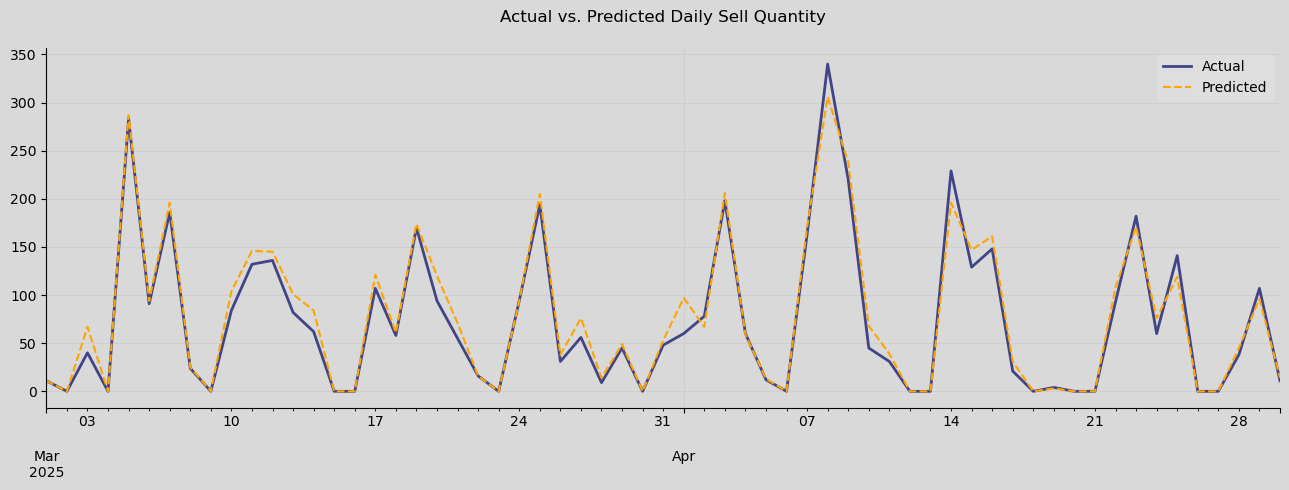

In [12]:
def PlotActPred(df, save):
    set_plot_style()
    df.set_index('date')['y_test'].plot(color = corViridis[1], linewidth = 2, label = 'Actual')
    df.set_index('date')['y_pred'].plot(color = 'orange', label = 'Predicted', linestyle = '--')
    plt.title('Actual vs. Predicted Daily Sell Quantity\n')
    legend = plt.legend()
    legend.get_frame().set_facecolor('0.88')
    legend.get_frame().set_edgecolor('0.88')
    plt.grid(visible = True, color = '0.81')
    plt.xlabel("")
    plt.ylabel("")
    plt.gcf().set_size_inches(13, 5)
    
    plt.tight_layout()
    plt.savefig(save)
    
    plt.show()
    plt.close()


PlotActPred(df, "../visuals/43.ActualvPredictedDailySellQuantity.svg")

## **MODEL REFINEMENT**

### **FEATURE IMPORTANCE**

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats = 10, random_state = 13)

xgb_importance = pd.Series(model.feature_importances_, index = X_val.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = X_val.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = X_val.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.487695,1.133275,0.667692
sell_value,0.106115,0.341238,0.066904
inventory_lag_1,0.011636,0.257757,0.017608
daily_balance,0.023839,0.221135,0.136855
is_weekend,0.308086,0.150041,0.032376
buy_quantity,0.011233,0.139991,0.025222
rolling_std_sell_value,0.005392,0.017223,-0.000179
incc_monthly_change,0.002690,0.016385,-0.000611
fuel_price_vs_buy_value,0.003479,0.013037,-0.001049
month,0.011947,0.011357,0.000063


All three importance metrics for `fuel_price_pct_change` (XGBoost gain, SHAP, and permutation importance) returned a value of zero.

This confirms that the feature is not being utilized by the model in any meaningful way. Given its redundancy or lack of predictive contribution, we will remove this feature and retrain the model to evaluate any changes in performance.

In [17]:
X_train = X_train.drop('fuel_price_pct_change', axis = 1).copy()
X_val = X_val.drop('fuel_price_pct_change', axis = 1).copy()
X_test = X_test.drop('fuel_price_pct_change', axis = 1).copy()

In [18]:
model = XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 13,
    early_stopping_rounds = 20,
    eval_metric = 'rmse'
)

model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_2"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2
MAE,0.1130,0.1090
RMSE,0.1710,0.1700
R²,0.9927,0.9928


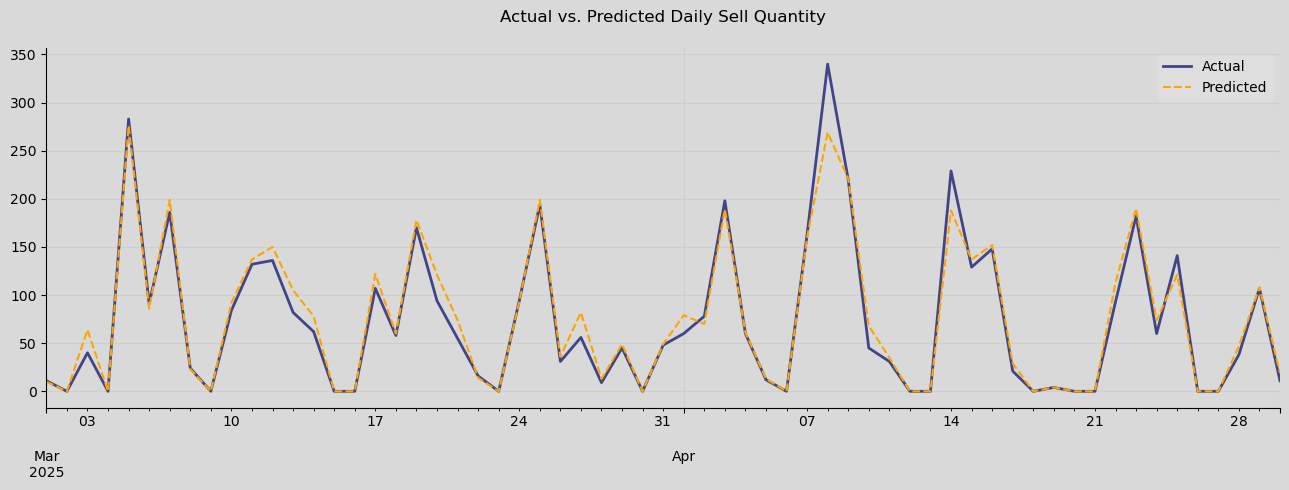

In [20]:
PlotActPred(df, "../visuals/44.ActualvPredictedDailySellQuantity.svg")

After excluding the `fuel_price_pct_change` feature, model performance slightly improved across all key metrics. This confirms that the feature was not only unused, but also introduced noise. Its removal helped the model generalize slightly better on unseen data.

### **HYPERPARAMETER TUNING**

#### **MANUAL**

In [109]:
param_grid = {
	'n_estimators':[300, 500, 700], # 500
	'learning_rate': [0.01, 0.05, 0.08], # 0.05
	'max_depth': [3, 5, 8], # 5
	'subsample': [0.6, 0.8, 1], # 0.8
	'colsample_bytree': [0.6, 0.8, 1], # 0.8
	'min_child_weight': [1, 3, 5],
	'gamma': [0, 0.1, 0.2, 0.3, 0.5],
	'reg_alpha': [0, 0.01, 0.1, 1],
	'reg_lambda': [1, 1.5, 2, 3]
}

model = XGBRegressor(
    random_state = 13,
    eval_metric = 'rmse'
)

model_CV = RandomizedSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_iter = 100, n_jobs = -1)
  
model_CV.fit(X_train, y_train)

model_CV.best_params_

{'subsample': 0.8,
 'reg_lambda': 2,
 'reg_alpha': 0,
 'n_estimators': 700,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.08,
 'gamma': 0,
 'colsample_bytree': 1}

In [113]:
param_grid = {
	'n_estimators':[700, 1000, 1300], # 500 -> 700
	'learning_rate': [0.08, 0.18, 0.28], # 0.05 -> 0.08
	'max_depth': [1, 2, 3], # 5 -> 3
	'min_child_weight': [0.1, 0.5, 1] # 1
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)
 
model_CV.fit(X_train, y_train)

model_CV.best_params_

{'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.1,
 'n_estimators': 1000}

In [117]:
param_grid = {
	'n_estimators':[700, 800, 900, 1000], # 500 -> 700 -> 1000
	'learning_rate': [0.28, 0.5, 0.7], # 0.05 -> 0.08 -> 0.28
	'max_depth': [2], # 5 -> 3 -> [2]
	'min_child_weight': [0.01, 0.05, 0.1] # 1 -> 0.2
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)

model_CV.fit(X_train, y_train)

model_CV.best_params_

{'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.01,
 'n_estimators': 800}

In [121]:
param_grid = {
	'n_estimators':[800], # 500 -> 700 -> 1000 -> [800]
	'learning_rate': [0.28], # 0.05 -> 0.08 -> 0.28 -> [0.28]
	'max_depth': [2], # 5 -> 3 -> [2]
	'min_child_weight': [0.01, 0.05, 0.1], # 1 -> 0.2 -> 0.01,
	'reg_alpha': [0, 0.01, 0.1, 1], #0
	'reg_lambda': [1.5, 2, 3], #2
	'gamma': [0] # 0
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)

model_CV.fit(X_train, y_train)

model_CV.best_params_

{'gamma': 0,
 'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.01,
 'n_estimators': 800,
 'reg_alpha': 0.1,
 'reg_lambda': 3}

In [123]:
param_grid = {
	'n_estimators':[800], # 500 -> 700 -> 1000 -> [800]
	'learning_rate': [0.28], # 0.05 -> 0.08 -> 0.28 -> [0.28]
	'max_depth': [2], # 5 -> 3 -> [2]
	'min_child_weight': [0.01], # 1 -> 0.2 -> 0.01 ->[0.01]
	'reg_alpha': [0.05, 0.08, 0.1], #0 -> 0.1
	'reg_lambda': [2], #2 -> [2]
	'gamma': [0] # 0 -> [0] Default
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)

model_CV.fit(X_train, y_train)

model_CV.best_params_

{'gamma': 0,
 'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.01,
 'n_estimators': 800,
 'reg_alpha': 0.08,
 'reg_lambda': 2}

In [125]:
param_grid = {
	'n_estimators':[800], # 500 -> 700 -> 1000 -> [800]
	'learning_rate': [0.28], # 0.05 -> 0.08 -> 0.28 -> [0.28]
	'max_depth': [2], # 5 -> 3 -> [2]
	'min_child_weight': [0.01], # 1 -> 0.2 -> 0.01 ->[0.01]
	'reg_alpha': [0.06, 0.07, 0.08], #0 -> 0.1 -> 0.08
	'reg_lambda': [2], #2 -> [2]
	'gamma': [0] # 0 -> [0] Default
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)

model_CV.fit(X_train, y_train)

model_CV.best_params_

{'gamma': 0,
 'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.01,
 'n_estimators': 800,
 'reg_alpha': 0.06,
 'reg_lambda': 2}

In [127]:
param_grid = {
	'n_estimators':[800], # 500 -> 700 -> 1000 -> [800]
	'learning_rate': [0.28], # 0.05 -> 0.08 -> 0.28 -> [0.28]
	'max_depth': [2], # 5 -> 3 -> [2]
	'min_child_weight': [0.01], # 1 -> 0.2 -> 0.01 ->[0.01]
	'reg_alpha': [0.05, 0.055, 0.06], #0 -> 0.1 -> 0.08 -> 0.06
	'reg_lambda': [2], #2 -> [2]
	'gamma': [0] # 0 -> [0] Default
}

model_CV = GridSearchCV(model, param_grid, cv = 3, scoring = "neg_root_mean_squared_error", n_jobs = -1)

model_CV.fit(X_train, y_train)

model_CV.best_params_

{'gamma': 0,
 'learning_rate': 0.28,
 'max_depth': 2,
 'min_child_weight': 0.01,
 'n_estimators': 800,
 'reg_alpha': 0.06,
 'reg_lambda': 2}

In [135]:
model = XGBRegressor(
    n_estimators = 800, # 500 -> 700 -> 1000 -> [800]
	learning_rate = 0.28, # 0.05 -> 0.08 -> 0.28 -> [0.28]
	max_depth = 2, # 5 -> 3 -> [2]
	min_child_weight = 0.01, # 1 -> 0.2 -> 0.01 ->[0.01]
	reg_alpha = 0.06, #0 -> 0.1 -> 0.08 -> 0.06 -> [0.06]
	reg_lambda = 2, #2 -> [2]
	gamma = 0, # 0 -> [0] Default
    random_state = 13,
    eval_metric = 'rmse'
)

model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.28, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=0.01, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [137]:
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.1130,0.1090,0.1480
RMSE,0.1710,0.1700,0.2160
R²,0.9927,0.9928,0.9884
